In [10]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pymc3 as pm

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

In [12]:
df = pd.read_csv(r'../student-mat.csv')
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [13]:
df = df[~df['G3'].isin([0, 1])]
df.shape

(633, 33)

In [14]:
df = df.rename(columns={'G3': 'Grade'})

In [15]:
df.corr()['Grade'].abs().sort_values()

age           0.042505
famrel        0.072888
health        0.096461
freetime      0.105206
goout         0.111228
traveltime    0.129654
Walc          0.178839
Dalc          0.196891
absences      0.204230
Fedu          0.204392
studytime     0.249855
Medu          0.278690
failures      0.384569
G1            0.874777
G2            0.942691
Grade         1.000000
Name: Grade, dtype: float64

In [16]:

dummy_df=pd.get_dummies(df)
dummy_df['Grade']=df['Grade']
dummy_df.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,1,0,0,1,0,1,1,0,1,0
1,17,1,1,1,2,0,5,3,3,1,...,1,0,1,0,0,1,0,1,1,0
2,15,1,1,1,2,0,4,3,2,2,...,1,0,0,1,0,1,0,1,1,0
3,15,4,2,1,3,0,3,2,2,1,...,0,1,0,1,0,1,0,1,0,1
4,16,3,3,1,2,0,4,3,2,1,...,1,0,0,1,0,1,1,0,1,0


In [17]:
dummy_df.corr()['Grade'].abs().sort_values()

famsup_yes           0.001581
famsup_no            0.001581
Pstatus_T            0.001776
Pstatus_A            0.001776
Mjob_services        0.006210
guardian_mother      0.008042
famsize_LE3          0.012957
famsize_GT3          0.012957
Fjob_other           0.021292
Fjob_health          0.026320
Mjob_other           0.035494
Fjob_services        0.042497
age                  0.042505
reason_home          0.046639
Fjob_at_home         0.049372
romantic_yes         0.052050
romantic_no          0.052050
nursery_no           0.056449
nursery_yes          0.056449
guardian_father      0.066486
paid_no              0.067146
paid_yes             0.067146
famrel               0.072888
activities_yes       0.078526
activities_no        0.078526
reason_other         0.092382
Mjob_health          0.092483
health               0.096461
schoolsup_no         0.098185
schoolsup_yes        0.098185
guardian_other       0.100802
freetime             0.105206
goout                0.111228
sex_M     

In [18]:
def format_data(df):
    df=df.drop(columns=['school','G1','G2'])
    df=pd.get_dummies(df)
    labels = df['Grade']
    most_correlated = df.corr().abs()['Grade'].sort_values(ascending=False)
    most_correlated=most_correlated[:8]
    df = df.loc[:, most_correlated.index]
    df = df.drop(columns = 'higher_no')
    X_train, X_test, y_train, y_test = train_test_split(df, labels,test_size = 0.25,random_state=42)
    return X_train,X_test,y_train,y_test

In [19]:
X_train,X_test,y_train,y_test=format_data(df)

In [20]:
X_train.head()

,Grade,failures,higher_yes,Medu,studytime,Fedu,absences
619,13,0,1,3,2,3,6
323,10,0,1,4,1,3,0
201,16,0,1,2,2,1,0
410,17,0,1,2,2,2,0
426,11,0,1,3,1,3,4


In [21]:
X_train = X_train.rename(columns={'higher_yes': 'higher_edu', 
                                  'Medu': 'mother_edu',
                                  'Fedu': 'father_edu'})

X_test = X_test.rename(columns={'higher_yes': 'higher_edu', 
                                  'Medu': 'mother_edu',
                                  'Fedu': 'father_edu'})

In [22]:
def evaluate(X_train, X_test, y_train, y_test):
    model_name_list = ['Linear Regression', 'ElasticNet Regression',
                      'Random Forest', 'Extra Trees', 'SVM',
                       'Gradient Boosted', 'Baseline']
    X_train = X_train.drop(columns='Grade')
    X_test = X_test.drop(columns='Grade')
    
    model1 = LinearRegression()
    model2 = ElasticNet(alpha=1.0, l1_ratio=0.5)
    model3 = RandomForestRegressor(n_estimators=50)
    model4 = ExtraTreesRegressor(n_estimators=50)
    model5 = SVR(kernel='rbf', degree=3, C=1.0, gamma='auto')
    model6 = GradientBoostingRegressor(n_estimators=20)
    
    results = pd.DataFrame(columns=['mae', 'rmse'], index = model_name_list)
    
    for i, model in enumerate([model1, model2, model3, model4, model5, model6]):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        

        mae = np.mean(abs(predictions - y_test))
        rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
        
        
        model_name = model_name_list[i]
        results.loc[model_name, :] = [mae, rmse]
    
    
    baseline = np.median(y_train)
    baseline_mae = np.mean(abs(baseline - y_test))
    baseline_rmse = np.sqrt(np.mean((baseline - y_test) ** 2))
    
    results.loc['Baseline', :] = [baseline_mae, baseline_rmse]
    return results

In [23]:
res = evaluate(X_train,X_test,y_train,y_test)
print(res)

                           mae     rmse
Linear Regression       1.8859  2.27395
ElasticNet Regression  2.09282  2.53656
Random Forest          1.89151  2.36486
Extra Trees            1.93572  2.45268
SVM                    1.90262  2.30825
Gradient Boosted       1.81272  2.22737
Baseline                2.1761  2.67765


In [24]:
formula = 'Grade ~ ' + ' + '.join(['%s' % variable for variable in X_train.columns[1:]])
formula

'Grade ~ failures + higher_edu + mother_edu + studytime + father_edu + absences'

In [25]:
with pm.Model() as normal_model:
    family = pm.glm.families.Normal()
    pm.GLM.from_formula(formula, data = X_train, family = family)
    normal_trace = pm.sample(draws=2000, chains = 2, tune = 500)
    normal_trace = normal_trace[1000:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sd, absences, father_edu, studytime, mother_edu, higher_edu, failures, Intercept]


Sampling 2 chains for 500 tune and 2_000 draw iterations (1_000 + 4_000 draws total) took 1719 seconds.
The acceptance probability does not match the target. It is 0.8899860395314885, but should be close to 0.8. Try to increase the number of tuning steps.


In [26]:
print(normal_trace)

<MultiTrace: 2 chains, 1000 iterations, 9 variables>


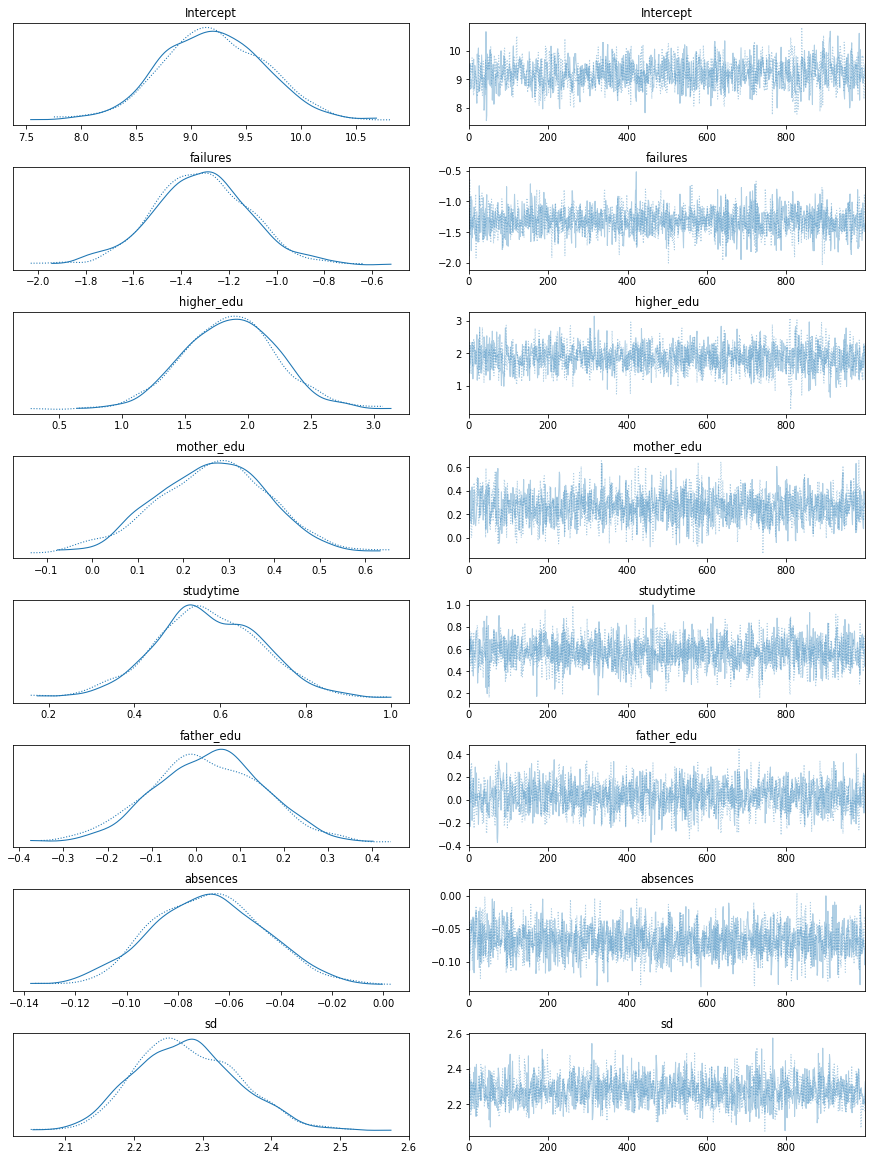

In [27]:
pm.traceplot(normal_trace);

In [28]:
model_formula = 'Grade = '
for variable in normal_trace.varnames:
    model_formula += ' %0.2f * %s +' % (np.mean(normal_trace[variable]), variable)

' '.join(model_formula.split(' ')[:-1])

'Grade =  9.20 * Intercept + -1.32 * failures + 1.86 * higher_edu + 0.27 * mother_edu + 0.57 * studytime + 0.03 * father_edu + -0.07 * absences + 0.82 * sd_log__ + 2.28 * sd'

In [29]:
def eval_trace(X_test,y_test,trace):
  var_dict={}
  for variable in trace.varnames:
    var_dict[variable]=trace[variable]
  var_weights = pd.DataFrame(var_dict)
  var_means = var_weights.mean(axis=0)
  X_test['Intercept'] = 1
  names = X_test.columns[1:]
  X_test = X_test.loc[:, names]
  var_means = var_means[names]
  results = pd.DataFrame(index = X_test.index, columns = ['estimate'])
  for row in X_test.iterrows():
        results.loc[row[0], 'estimate'] = np.dot(np.array(var_means), np.array(row[1]))
  actual = np.array(y_test)
  errors = results['estimate'] - actual
  mae = np.mean(abs(errors))
  rmse = np.sqrt(np.mean(errors ** 2))
  return mae , rmse

In [30]:
mae ,rmse =eval_trace(X_test,y_test,normal_trace)

In [31]:
res.loc['Bayesian Linear Regression', :]=[mae,rmse]

In [32]:
res.sort_values(by=['mae','rmse'])

,mae,rmse
Gradient Boosted,1.81272,2.22737
Bayesian Linear Regression,1.88578,2.27368
Linear Regression,1.8859,2.27395
Random Forest,1.89151,2.36486
SVM,1.90262,2.30825
Extra Trees,1.93572,2.45268
ElasticNet Regression,2.09282,2.53656
Baseline,2.1761,2.67765
